# Project in Data Mining
Team Members: Fotini Tsavo (1115201500206) & Anna-Aikaterini Kavvada (1115201500050)

A Sentiment Analysis project, that its purpose is to identify and categorize views expressed in a piece of text,in order to determine whether the author's attitude towards a particular subject is positive, neutral or negative.

This is all we have to run before unpickling our data.

In [1]:
import re
from string import digits
import csv
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import pickle

def shallow_cleaning(data):
    remove_digits = str.maketrans('', '', digits)
    for i in range(len(data)):
        data[i] = re.sub('[\W_]+', ' ', str(data[i])) #we want to keep the blank spaces between words
        data[i] = re.sub(r'[0-9]+', '', data[i])
        data[i] = data[i].lower()
    return data

To begin with, in the box below we have parsed the tsv file, which holds the tweets that we are going to study.

In [2]:
path = os.path.abspath("../twitter_data/train2017.tsv")
path_test = os.path.abspath("../twitter_data/test2017.tsv")
#function that helps us open a tsv file and parse it to a list of lists
def my_open_file(path):
    with open(path,encoding="utf8") as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONE)
        data = list(tsvreader)
        return data
    
train_data = my_open_file(path)
test_data = my_open_file(path_test)
#you are not able to print all data here because the rate limits won't allow you to  

# Data Cleaning
While looking at the tsv file, we noticed that the three first words are unnecessary because they do not express any emotion, so we eliminate them.

In [3]:
#Starting with the data cleaning process, we pop the two first elements from each list 
def pop_two_first(data):
    for i in range(len(data)):
        data[i].pop(0)
        data[i].pop(0)
    return data

train_data = pop_two_first(train_data)
test_data = pop_two_first(test_data)

Tweets contain some symbols and numbers that are not very helpful for our research.

In [4]:
train_data = shallow_cleaning(train_data)
test_data = shallow_cleaning(test_data)

The funtion below does a deep cleaning of our data. Firstly, we tokenize in order to remove some stop words and some othet words that are not useful for our research. We have done the tokenization step and removal of stop words before lemmatizing because if we had done the opossite a word such as 'sh' could not have been removed. 
Furthermore, we created a new list that contains strings, those strings are our tweets.

In [5]:
data_copy = []
data_copy_test = []
def deep_cleaning(data,data_copy):
    ps = WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    base_words = []
    for i in range(len(data)):
        sentence = nltk.word_tokenize(data[i])
        sentence = [word for word in sentence if word not in stopwords]
        sent = pos_tag(sentence)
        clean_sent = [s for s in sent if s[1]!='ADP' and s[1]!='IN' and s[1]!='TO' and s[1]!='NUM' and s[1]!='PRT' and s[1]!='PRON' ]
        for tag in clean_sent:
            base_word = ps.lemmatize(tag[0].lower(),'a')
            base_words.append(base_word)
        data_copy.append(str(base_words))
        base_words.clear()      #so that we don't append the words of another line, we should reset the list
    return data_copy

train_data = deep_cleaning(train_data,data_copy)

In [6]:
test_data = deep_cleaning(test_data,data_copy_test)

We have just implemented a simple function that creaetes a pickle file. We create two files, one that will hold our train tweets and the other one that will hold our test tweets.

In [7]:
def pickling_data(data_list,filename):
    output_file = open(filename,'wb')
    pickle.dump(data_list,output_file)   #function dump takes two args:the object you want to pickle and the file you want to save it in 
    output_file.close()
    
pickling_data(train_data,'train')
pickling_data(test_data,'test')

# Start running here the program
Loading pickle files is much faster than having to compile each time our code. So the function that unpickles the fiels that we will store is of a great use to us.

In [8]:
def unpickle_file(filename):
    input_file = open(filename,'rb')   # r = read mode , b = binary mode
    new_list = pickle.load(input_file)
    input_file.close()
    return new_list   

train_data = unpickle_file('train')
test_data = unpickle_file('test')

The function below removes some labels and helps us for our data cloud representation. Otherwise the words 'positive', 'negative', 'neutral' or 'unknown' will be appear as the bigger words in our wordclouds, because they are more frequently used.

In [9]:
def remove_labels(allData):
    data = allData
    data = shallow_cleaning(data)
    my_stopwords = ['positive','negative','neutral','unknown','co']
    for i in range(len(data)):
        sentence = nltk.word_tokenize(data[i])
        sentence = [word for word in sentence if word not in my_stopwords]
        data[i] = sentence
    return data

# What is the most frequent word in our train set and our test set?
This question is answered with the wordclouds below. Seems that our train set contains tweets about "tomorrow".
Most tweets that we find in the test are about Trump.

In [10]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open(requests.get('https://images.techhive.com/images/article/2016/02/twitter-icon-logo-100644740-large.jpg', stream=True).raw))
# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(data, mask):
    allData = data
    allData = remove_labels(allData)
    allData = shallow_cleaning(allData)
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask).generate(str(allData))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

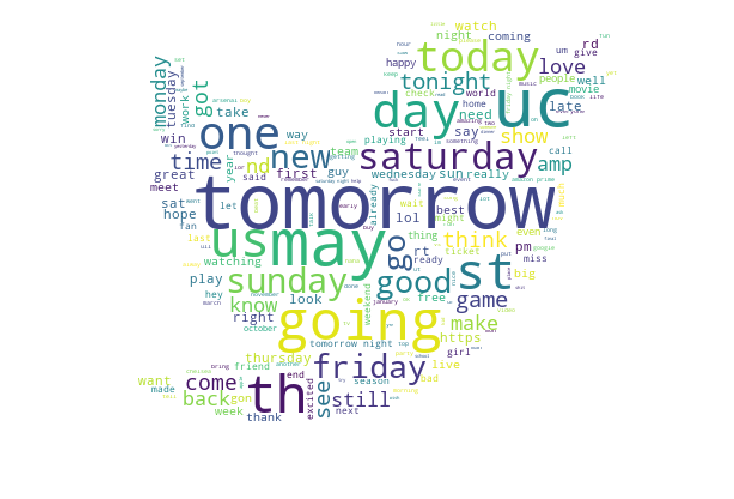

In [11]:
temp_train_data = train_data.copy()
generate_wordcloud(temp_train_data, mask)

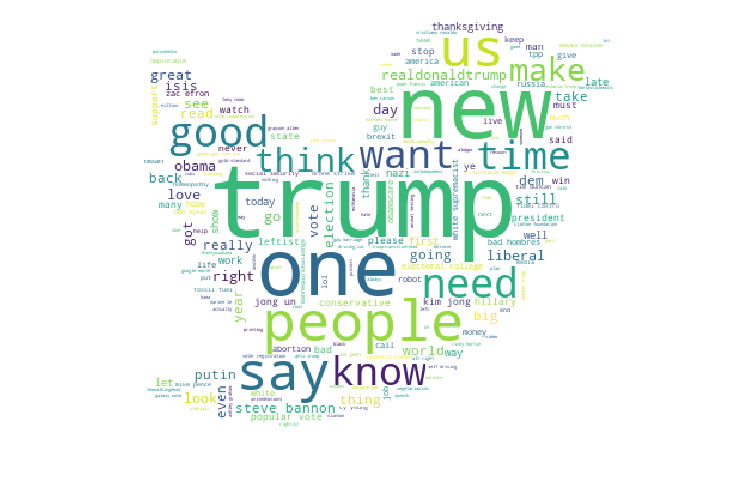

In [12]:
temp_test_data = test_data.copy()
generate_wordcloud(temp_test_data, mask)

Below we have a function that creates a list according to the emotion that we pass as a parameter. In our case, three lists are created grouped by the emotion. This has been done in order to create word clouds that represent each emotion.

In [13]:
def emotion_list(data,emotion):
    distinguish_list = []
    data = shallow_cleaning(data)
    for i in range(len(data)):
        sentence = nltk.word_tokenize(data[i])
        if sentence[0] == emotion:
            distinguish_list.append(sentence)
    return distinguish_list
positive_train_list = emotion_list(train_data,"positive")
negative_train_list = emotion_list(train_data,"negative")
neutral_train_list = emotion_list(train_data,"neutral")


A wordcloud that is the representation of the words icluded in the positive tweets in our train set.

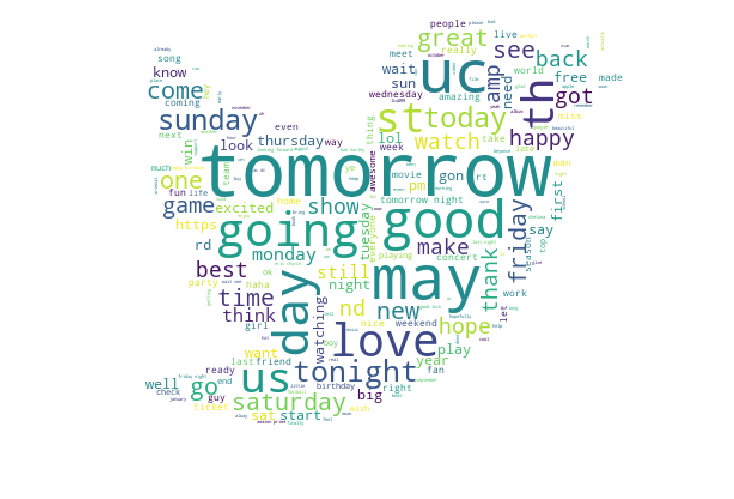

In [14]:
generate_wordcloud(positive_train_list,mask)

Negative tweets representation.

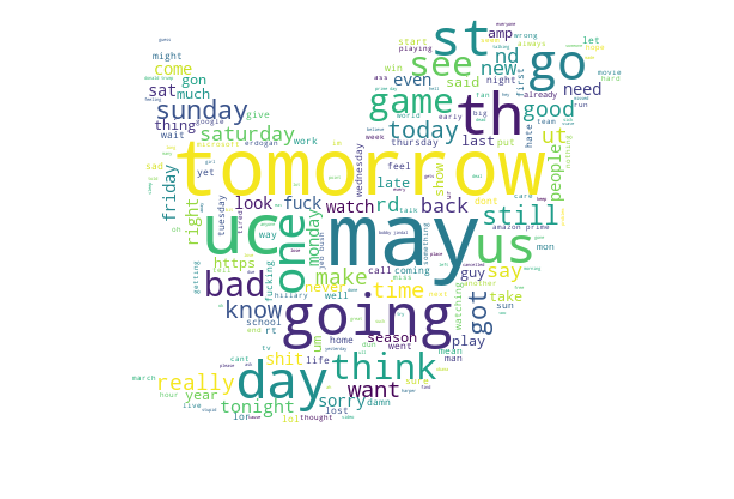

In [15]:
generate_wordcloud(negative_train_list,mask)

Neutral tweets representation.

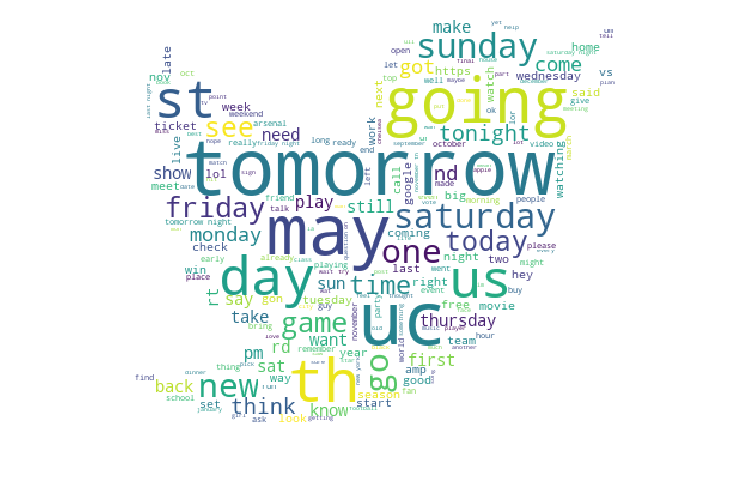

In [16]:
generate_wordcloud(neutral_train_list,mask)

In [17]:
def tokenize(data):
    for i in range(len(data)):
        data[i] = nltk.word_tokenize(data[i])
    return data

tokenized_train_data = train_data.copy()
tokenized_test_data = test_data.copy()
tokenized_train_data = tokenize(tokenized_train_data)
tokenized_test_data = tokenize(tokenized_test_data)

# Bag of Words
Bag of Words is the method that we are going to use, in order to extract features from our data tweet. In simple words, it is a collection of words to represent a sentence with word count and mostly disregarding the order in which they appear. So for this purpose, we are going to use the vocabulary that has been created in the above cell.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

data = unpickle_file('train')
vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=1000)
train_bow = vectorizer.fit_transform(data)
train_bow = train_bow.toarray()
data1 = unpickle_file('test')
test_bow= vectorizer.transform(data1)
test_bow = test_bow.toarray()

We have three labels neutral, positive and negative, therefore we design a list that we cast into an array later that will hold only those labels with numbers that represent our labels. 

In [19]:
import numpy as np 
from sklearn.model_selection import train_test_split
c = []
for i in range(len(tokenized_train_data)):
    if tokenized_train_data[i][0] == 'neutral':
        c.append(0)
    elif tokenized_train_data[i][0] == 'positive':
        c.append(1)
    elif tokenized_train_data[i][0] == 'negative':
        c.append(2)
c = np.array(c)

X_train, X_valid, Y_train, Y_valid = train_test_split(train_bow,c,random_state = 42,test_size = 0.2)

The parameter in the f1_score function "average = macro " is used because we have multiclass.

In [20]:
from sklearn import svm
from sklearn import metrics

def svm_clf(X_train,X_valid,Y_train,Y_valid):
    
    clf = svm.SVC(kernel='linear') # Linear Kernel
    clf.fit(X_train, Y_train)
    
    y_pred = clf.predict(X_valid)
    train_accuracy = metrics.f1_score(Y_valid, y_pred, average='macro') 
    print("SVM_train_accuracy = ",train_accuracy)
       
    return clf

clf = svm_clf(X_train,X_valid,Y_train,Y_valid)

test_prediction_svm = clf.predict(test_bow)




SVM_train_accuracy =  0.9994821845239104


In [21]:
def create_file(data, prediction,filename):
    with open(filename, "w") as csvfile4:
        fieldnames = ['Twit', 'Predicted_Sentiment']
        writer = csv.DictWriter(csvfile4, fieldnames=fieldnames)
        writer.writeheader()
        for x in range(len(prediction)):
            writer.writerow({'Twit': data[x], 'Predicted_Sentiment': prediction[x]})
        
prediction_file_svm = create_file(temp_test_data, test_prediction_svm, 'test_prediction_svm')
pickling_data(prediction_file_svm,'test_prediction_svm_pkl')

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def knn(X_train,X_valid,Y_train,Y_valid):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,Y_train)
    y_pred = knn.predict(X_valid)
    accuracy = metrics.accuracy_score(Y_valid, y_pred)
    print("KNN_accuracy = ", accuracy)
    return knn



In [ ]:
knn = knn(X_train,X_valid,Y_train,Y_valid)

test_knn_prediction = knn.predict(test_bow)

prediction_file_knn = create_file(temp_test_data, test_knn_prediction, 'test_knn_prediction')
pickling_data(prediction_file_knn,'test_knn_prediction_pkl')

# Tf-IDF 
The function below will help us to find the numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = unpickle_file('train')
vectorizer1 = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000)
train_tfidf = vectorizer1.fit_transform(data)
train_tfidf = train_tfidf.toarray()
test_tfidf= vectorizer1.transform(data1)
test_tfidf = test_tfidf.toarray()

print(test_tfidf.shape)


(106, 1000)


In [25]:
X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split(train_tfidf,c,random_state = 42,test_size = 0.2)
svm_tfidf = svm_clf(X_train1,X_valid1,Y_train1,Y_valid1)

test_svm_pred_tfidf = svm_tfidf.predict(test_tfidf)

prediction_file_svm_tfidf = create_file(temp_test_data, test_svm_pred_tfidf, 'prediction_file_svm_tfidf')
pickling_data(prediction_file_svm_tfidf,'prediction_file_svm_tfidf_pkl')

SVM_train_accuracy =  0.9111111111111111


In [26]:
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(X_train1,Y_train1)
y_pred = knn_tfidf.predict(X_valid1)
accuracy_tfidf = metrics.accuracy_score(Y_valid1, y_pred)
print("KNN_accuracy_tfidf = ", accuracy_tfidf)

test_knn_pred_tfidf = knn_tfidf.predict(test_tfidf)

prediction_file_knn_tfidf = create_file(temp_test_data, test_knn_pred_tfidf, 'prediction_file_knn_tfidf')
pickling_data(prediction_file_knn_tfidf,'prediction_file_knn_tfidf_pkl')

KNN_accuracy_tfidf =  0.6363636363636364


# Word Embedding
We will start with a function that creates the model for us.

In [27]:
import warnings
import gensim
import pandas as pd
from gensim.models import Word2Vec
import warnings


def create_model(data):
    warnings.filterwarnings(action = 'ignore')
    model_w2v = gensim.models.Word2Vec(data, min_count=2, size=30) 
    
    return model_w2v


model = create_model(tokenized_train_data)

Next step is to save our model to a pickle file, thus we save time by not re-running our piece of code.

In [28]:
pickling_data(model,'model')
model = unpickle_file('model')

We need to count the words that the vocabulary contains. As a result we had to built a function that iterates over each list of our lists and counts the all the words that all of our documents combined have.

In [31]:
def count_return(data):
    count = 0 
    for item in data:
        for jtem in item:
            count += 1
    return count

count = count_return(tokenized_train_data)

model.train(tokenized_train_data,total_examples = count,epochs=model.epochs)

(6306, 14245)

Building seperated vocabularies, one for each set.

In [56]:
def voc_building(model):
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model[word])
    return tokens
tokens = voc_building(model)

In [57]:
affin_path_lexica = os.path.abspath("../lexica/affin/affin.txt")
emotweet_path_lexica = os.path.abspath("../lexica/emotweet/valence_tweet.txt")
generic_path_lexica = os.path.abspath("../lexica/generic/generic.txt")
nrc_path_lexica = os.path.abspath("../lexica/nrc/val.txt")
nrctag_path_lexica = os.path.abspath("../lexica/nrctag/val.txt")

affin_lex = my_open_file(affin_path_lexica)
emotweet_lex = my_open_file(emotweet_path_lexica)
generic_lex = my_open_file(generic_path_lexica)
nrc_lex = my_open_file(nrc_path_lexica)
nrctag_lex = my_open_file(nrctag_path_lexica)


def convert_to_string(data):
    for i in range(len(data)):
        data[i] = str(data[i])
    return data

temp_tokens = tokens.copy()


In [58]:
def my_labels(model):
    labels = []
    for word in model.wv.vocab:
        labels.append(word)
    return labels
labels = my_labels(model)

In [59]:
def add_to_vector(lexica, vector, labels):
    labels = convert_to_string(labels)
    for i in range(len(lexica)):
        lexica[i][0] = str(lexica[i][0])
    for j in range (len(labels)):
        for i in range(len(lexica)):
            if labels[j] == lexica[i][0]:
                vector[j] = np.append(vector[j], lexica[i][1])
            else:
                vector[j] = np.append(vector[j], "0")
    return vector
                
    
my_vec = add_to_vector(affin_lex,temp_tokens,labels)
#myvec = add_to_vector(generic_lex,my_vec,labels)



For the functions below we have followed the code that was suggested in our lectures.

In [60]:
import sklearn
from sklearn.manifold import TSNE
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 0)

In [61]:
import numpy as np 
new_values = tsne.fit_transform(np.array(my_vec))

Creating the points that we are going to use, to finally visualize our data. 

In [54]:
x = []
y = []
x1 = []
y1 = []

for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
for value1 in new_values_test:
    x1.append(value1[0])
    y1.append(value1[1])

In [62]:
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(new_values,labels,random_state = 42,test_size = 0.2)
svm_we = svm_clf(X_train2, X_valid2, Y_train2, Y_valid2)

#test_svm_pred_we = svm_we.predict(temp_test_data)

#prediction_file_svm_we = create_file(temp_test_data, test_svm_pred_we, 'prediction_file_svm_we')
#pickling_data(prediction_file_svm_we,'prediction_file_svm_we_pkl')

SVM_train_accuracy =  0.0


In [64]:
knn_we = KNeighborsClassifier(n_neighbors=5)
knn_we.fit(X_train2,Y_train2)
y_pred = knn_we.predict(X_valid2)
accuracy_we_knn = metrics.accuracy_score(Y_valid2, y_pred)
print("KNN_accuracy_tfidf = ", accuracy_we_knn)

KNN_accuracy_tfidf =  0.0


In [67]:
def plot_tsne(labels,x,y):
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
           textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
#plot_tsne(labels_test,x1,y1)

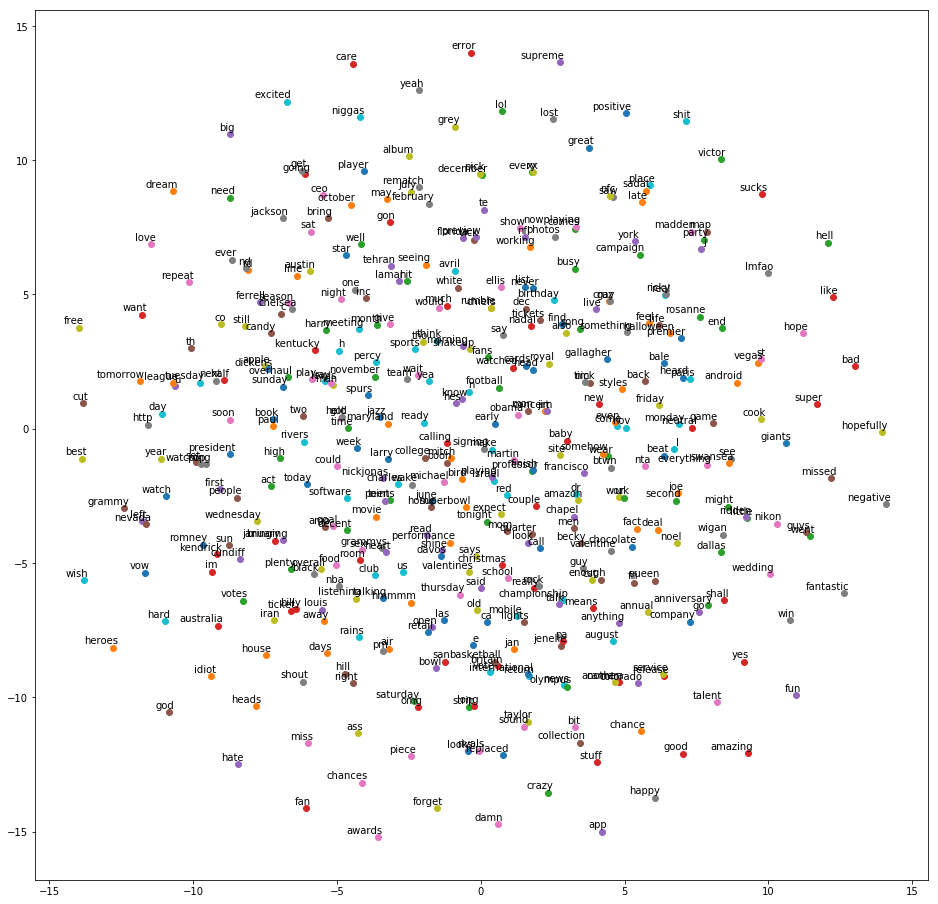

In [68]:
plot_tsne(labels,x,y)